In [1]:
import json
import os
import sys
import itertools
import collections
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
import numpy as np
from gensim import corpora, models
from gensim.corpora import Dictionary
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pandas as pd
import random
import networkx as nx

from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px

import pyLDAvis
import pyLDAvis.gensim
import community

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sdmohant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 80)

pd.set_option('max_colwidth', 80)

## Data Load and Cleanup

#### Load up data

All level courses

In [3]:
course_df = pd.read_csv('../data/Course_data.tsv', sep='\t')

In [4]:
total_rows=len(course_df.axes[0])
total_cols=len(course_df.axes[1])
print("Number of Rows: "+str(total_rows))
print("Number of Columns: "+str(total_cols))

print("\nData Columns:")
for each in list(course_df.columns.values):
    print each

Number of Rows: 5053
Number of Columns: 16

Data Columns:
SCBCRSE_SUBJ_CODE
SUBJ_DESC
SCBCRSE_CRSE_NUMB
College
COLL_DESC
Department
DEPT_DESC
Title
Long_Title
Status
Last_Taught
Schedule_Codes
CIP_Code
Course_Prerequisites
Course_Corequisites
COURSE_DESC


Drop any courses which do not have a course description

In [5]:
course_df.dropna(subset=['COURSE_DESC'], inplace=True)

In [6]:
course_df.iloc[3].COURSE_DESC

'Students will learn about their own work style and best practices of leading and managing people and teams in the specific context of arts and creative organizations.  Prerequisite: AAD/ENT 202 Arts Administration or permission of instructor.'

In [8]:
total_rows=len(course_df.axes[0])
print("Number of Courses: "+str(total_rows))

Number of Courses: 4887


#### Perform PreReq, CoReq, and Notes Cleanup on Dataframe

Remove pre-requisite ,co-requisite, and notes from the course description

In [9]:
def cleanup(x):
    return x.split('Prerequisite')[0].split('Corequisite')[0].split('Note')[0].strip()

course_df.COURSE_DESC = course_df.COURSE_DESC.apply(cleanup) # remove prereq and coreq text

Clean non-ascii characters

In [10]:
import string

def remove_chars(x):

    alpha = list(string.ascii_uppercase)

    for i in alpha:

        x = x.replace(i, '')

    return int(x)

course_df['course_num_clean'] = course_df.SCBCRSE_CRSE_NUMB.apply(remove_chars) # clean ascii
course_df['course_code'] = course_df['SCBCRSE_SUBJ_CODE'].astype(str) + '-' + course_df['course_num_clean'].astype(str) # merge dept code with course num

In [11]:
course_df.iloc[3].COURSE_DESC

'Students will learn about their own work style and best practices of leading and managing people and teams in the specific context of arts and creative organizations.'

#### Remove generic courses

In [12]:
to_remove = ['Experimental Course','','Thesis','Thesis Extension','Dissertation Extension',
             'Independent Study','Dissertation','Independent Doctoral Research', 'Clinical Supervision',
             'Counseling Internship','Directed Doctoral Research','Independent Study','Advanced Counseling Internship',
             'Doctoral Dissertation Research','Research Extension','Directed Research','Internship','Directed Reading']

In [13]:
course_df = course_df.loc[course_df.Long_Title.apply(lambda x : type(x) != float and x.strip() not in to_remove)] # remove the common subjects

In [14]:
course_df.iloc[3].COURSE_DESC

'Marketing, sales and public relations strategy, planning and tactics for arts organizations and businesses.'

In [16]:
total_rows=len(course_df.axes[0])
total_cols=len(course_df.axes[1])
print("Number of Courses: "+str(total_rows))
print("Number of Columns: "+str(total_cols))

Number of Courses: 4367
Number of Columns: 18


#### List of Subject Areas

In [17]:
print("Subject Areas:")
for e1,e2,e3,e4,e5 in zip(*[iter(course_df.SUBJ_DESC.unique().tolist())]*5):
    print(e1,e2,e3,e4,e5)

Subject Areas:
('Arts Administration', 'Accounting', 'African Amrcn/African Diaspora', 'Apparel Product Design', 'Arabic')
('Archaeology', 'Art Education', 'Art History', 'Academic Recovery Seminar', 'Art')
('American Sign Language', 'Astronomy', 'Anthropology', 'Biology', 'Liberal Studies')
('Business Administration', 'Classical Civilization', 'Counseling and Ed Devlp', 'Chemistry', 'Chinese')
('Consumer, Apparel, Retail Stds', 'Computer Science', 'Comm Sciences and Disorders', 'Communication Studies', 'Comp Trans/Post Second Ed')
('Comm Therap/Recr Studies', 'Dance', 'Economics', 'Educ Ldrship and Cultrl Fndts', 'English')
('Music Ensemble', 'Entrepreneurship', 'Educatnl Research Methodology', 'English as a Second Language', 'Foundations for Learning')
('Finance', 'Freshman Seminars Program', 'French', 'First Year Experience', 'Genetic Counseling')
('German', 'Geogrphy,Envrnmnt,Sustainablty', 'Grogan College', 'Greek', 'Gerontology')
('Human Develp / Family Studies', 'Public Health',

Distribution of courses by department

In [22]:
sub_course_count = course_df.groupby(["SUBJ_DESC"]).SUBJ_DESC.agg('count').to_frame('Count').reset_index()
sub_course_count = sub_course_count.sort_values(by=['Count'], ascending=False)

fig = px.bar(sub_course_count, x='SUBJ_DESC', y='Count', labels={'SUBJ_DESC':'Subject Area', 'Count':'Total Number of Courses'})
fig.show()

Distribution of different levels of courses by department

In [23]:
def course_label(course_df):
    if course_df.course_num_clean < 300:
        val = 'Intro'
    elif (course_df.course_num_clean >= 300) & (course_df.course_num_clean < 500):
        val = 'Undergrad'
    else:
        val = 'Grad'
    return val

   

course_df['Course_Label'] = course_df.apply(course_label, axis=1)

test_df = pd.crosstab(course_df.SUBJ_DESC,course_df.Course_Label).reset_index()
test_df['total_count'] = test_df.Intro + test_df.Undergrad + test_df.Grad
test_df = test_df.sort_values(by=['total_count'], ascending=False)


fig = go.Figure(data=[
    go.Bar(name='Intro Courses', x=test_df.SUBJ_DESC, y=test_df.Intro),
    go.Bar(name='Undergrad Courses', x=test_df.SUBJ_DESC, y=test_df.Undergrad),
    go.Bar(name='Grad Courses', x=test_df.SUBJ_DESC, y=test_df.Grad)
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

#### Get Course Level

In [24]:
intro_df = course_df.loc[course_df.course_num_clean < 300]

undergrad_df = course_df.loc[(course_df.course_num_clean >= 300) & (course_df.course_num_clean < 500)]

grad_df = course_df.loc[course_df.course_num_clean >= 500]

In [25]:
intro_df.iloc[1].COURSE_DESC

'Introduction to external financial statements of organizations, emphasizing the use of accounting information in making investment and other decisions. Addresses ethical considerations and role of financial reporting in society.'

In [26]:
print("-"*40)
print("Introductory Courses: ")
total_rows=len(intro_df.axes[0])
print("Number of Courses: "+str(total_rows))
print("-"*40)

print("-"*40)
print("Undergraduate Courses: ")
total_rows=len(undergrad_df.axes[0])
print("Number of Courses: "+str(total_rows))
print("-"*40)

print("-"*40)
print("Graduate Courses: ")
total_rows=len(grad_df.axes[0])
print("Number of Courses: "+str(total_rows))
print("-"*40)



----------------------------------------
Introductory Courses: 
Number of Courses: 727
----------------------------------------
----------------------------------------
Undergraduate Courses: 
Number of Courses: 1949
----------------------------------------
----------------------------------------
Graduate Courses: 
Number of Courses: 1691
----------------------------------------


In [27]:
grad_df.head()

,SCBCRSE_SUBJ_CODE,SUBJ_DESC,SCBCRSE_CRSE_NUMB,College,COLL_DESC,Department,DEPT_DESC,Title,Long_Title,Status,Last_Taught,Schedule_Codes,CIP_Code,Course_Prerequisites,Course_Corequisites,COURSE_DESC,course_num_clean,course_code,Course_Label
32,ACC,Accounting,561,BE,Sch of Business and Economics,ACF,Accounting and Finance,Governmental and Nonprofit ACC,Governmental and Nonprofit Accounting,A,202001.0,LEC,520301,ACC 319[C],NaN,This course will introduce students to accounting and financial reporting fo...,561,ACC-561,Grad
34,ACC,Accounting,613,BE,Sch of Business and Economics,ACF,Accounting and Finance,Directed Studies in Accounting,Directed Studies in Accounting,A,202001.0,IND,520301,,NaN,Individual study of an issue or problem of interest. Student must arrange to...,613,ACC-613,Grad
35,ACC,Accounting,621,BE,Sch of Business and Economics,ACF,Accounting and Finance,Accounting Internship,Accounting Internship,A,202005.0,INT,520301,,NaN,Combined academic and work components allow students to gain experience in t...,621,ACC-621,Grad
36,ACC,Accounting,630,BE,Sch of Business and Economics,ACF,Accounting and Finance,Sem Contemporary Acc Issues,Seminar in Contemporary Accounting Issues,A,202001.0,LEC,520301,ACC 319[B-] or ACC 319[B-],NaN,"Analysis, research, and presentation of current topics and issues relevant t...",630,ACC-630,Grad
37,ACC,Accounting,631,BE,Sch of Business and Economics,ACF,Accounting and Finance,Advanced Auditing,Advanced Auditing,A,201908.0,LEC,520303,ACC 440[B-] or ACC 440[B-],NaN,"Ethics, reporting, law, statistics, and audit software; directed towards pro...",631,ACC-631,Grad


#### NLP on Course Decriptions

set the respective dataframe to data select course level. 

Simple preprocess https://radimrehurek.com/gensim/utils.html#gensim.utils.simple_preprocess

In [28]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

data = grad_df.COURSE_DESC.values.tolist() # set the dataframe here
data_words = list(sent_to_words(data))

In [29]:
len(data_words)

1691

Word frequency distribution for descriptions of graduate courses

In [30]:
hist_data = [len(x) for x in data_words]
fig = px.histogram(pd.DataFrame(hist_data, columns =['Document Word Frequency']), x="Document Word Frequency",
                  labels={'count':'Number of Words', 'Document Word Frequency':'Number of Documents'})
fig.show()

In [31]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

data = intro_df.COURSE_DESC.values.tolist() # set the dataframe here
data_words_intro = list(sent_to_words(data))

data = undergrad_df.COURSE_DESC.values.tolist() # set the dataframe here
data_words_under = list(sent_to_words(data))


data = grad_df.COURSE_DESC.values.tolist() # set the dataframe here
data_words_grads = list(sent_to_words(data))

Word frequency distribution for descriptions of each level of courses

In [32]:
hist_data_1 = [len(x) for x in data_words_intro]
hist_data_2 = [len(x) for x in data_words_under]
hist_data_3 = [len(x) for x in data_words_grads]

fig = go.Figure()
fig.add_trace(go.Histogram(x=hist_data_1, name='Intro'))
fig.add_trace(go.Histogram(x=hist_data_2, name='Undergrad'))
fig.add_trace(go.Histogram(x=hist_data_3, name='Graduate'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.65)
fig.show()

#### Course description preprocessing

Remove Stopwords, form Bigrams, Trigrams and Lemmatization

In [33]:
data_words[3]

[u'analysis',
 u'research',
 u'and',
 u'presentation',
 u'of',
 u'current',
 u'topics',
 u'and',
 u'issues',
 u'relevant',
 u'to',
 u'professional',
 u'accountants']

In [34]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

stop_words = stopwords.words('english')

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    ####Remove Stopwords, Form Bigrams, Trigrams and Lemmatization
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        sentence = " ".join(sent)
        doc = nlp(sentence.decode('utf-8', 'ignore')) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])

    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [35]:
len(data_ready)

1691

In [36]:
data_ready[3]

[u'presentation',
 u'current',
 u'topic',
 u'issue',
 u'relevant',
 u'professional',
 u'accountant']

## Topic Modeling

#### Text to vector transformations

In [37]:
from gensim.corpora import Dictionary

id2word = corpora.Dictionary(data_ready)

id2word.filter_extremes(no_below=0.95, no_above=2)

corpus = [id2word.doc2bow(text) for text in data_ready]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

#### Model Development - Evaluate Number of Topics Versus Perplexity / Coherence

http://qpleple.com/perplexity-to-evaluate-topic-models/

In [38]:
counter = collections.Counter(itertools.chain(*corpus))
number_of_words = sum(counter.values())

# number of topics range
parameter_list = range(5, 50, 2)

grid_perplex = {}
grid_coherence = {}


# calculate model, perplexity and coherence for the topics range
for parameter_value in parameter_list:
    grid_perplex[parameter_value] = []
    grid_coherence[parameter_value] = []
    
    print "#"*80 + '\n'
    print "starting pass for Topic Number = %d" % parameter_value
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=parameter_value, id2word=id2word, 
                                            passes=15,  alpha='symmetric', update_every=1,eta= 'auto', decay=0.5,
                                            chunksize=200) #auto alpha
    
    print "Model Created"
    perplex = lda_model.log_perplexity(corpus)
    print "Total Perplexity: %s" % perplex
    grid_perplex[parameter_value].append(perplex)

    per_word_perplex = np.exp2(-perplex / number_of_words)
    print "Per-word Perplexity: %s" % per_word_perplex
    grid_perplex[parameter_value].append(per_word_perplex)
    
    coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    print coherence_lda
    print('Coherence Score: %s' % coherence_lda)
    grid_coherence[parameter_value].append(per_word_perplex)
    
    print "#"*80 + '\n'

for numtopics in parameter_list:
    print numtopics, '\t',  grid_perplex[numtopics], '\t',  grid_coherence[numtopics]

################################################################################

starting pass for Topic Number = 5
Model Created
Total Perplexity: -7.233166133104875
Per-word Perplexity: 1.000248464969225
-6.279582771177396
Coherence Score: -6.279582771177396
################################################################################

################################################################################

starting pass for Topic Number = 7
Model Created
Total Perplexity: -7.282975753172131
Per-word Perplexity: 1.0002501761830205
-7.261150131164693
Coherence Score: -7.261150131164693
################################################################################

################################################################################

starting pass for Topic Number = 9
Model Created
Total Perplexity: -7.35810656310359
Per-word Perplexity: 1.0002527573140167
-8.222317330091622
Coherence Score: -8.222317330091622
#################################################

#### Normalizing / Standardization of Scores

In [39]:
### Normalization
df1 = pd.DataFrame(grid_perplex)
df1 = df1.transpose().apply(lambda x:(x-x.min()) / (x.max()-x.min())) ## Min Max Scaling
# df1 = df1.transpose().apply(lambda x: (x-x.mean())/ x.std()) ## Standardization
df2 = pd.DataFrame(grid_coherence)
df2 = df2.transpose().apply(lambda x:(x-x.min()) / (x.max()-x.min()))
# df2 = df2.transpose().apply(lambda x: (x-x.mean())/ x.std())

#### Perplexity vs Coherence Plot

In [40]:
x_ticks = df1.index.tolist()

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_ticks, y=df1.iloc[:,0], name='Topic Perplexity',
                         line=dict(color='firebrick', width=4)))

fig.add_trace(go.Scatter(x=x_ticks, y=df2.iloc[:,0], name='Coherence',
                         line=dict(color='royalblue', width=4, dash='dash')))

fig.update_layout(title='Perplexity and Coherence Vs Topics',
                   xaxis_title='Topics',
                   yaxis_title='Perplexity')
fig.show()

We choose 25 as it was a cross point between perplexity and coherence.

## LDA Model Final

In [41]:
model = gensim.models.ldamulticore.LdaModel(corpus=corpus, num_topics= 25,
                                            id2word=id2word, alpha='asymmetric', passes=15, eta= 'auto', decay=0.5, eval_every=1,
                                            chunksize=200, random_state = 10)
## chunk_size controls a good distribution of topics

# using tfidf
# model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf, id2word=id2word, num_topics=20, minimum_probability=1e-8,
#                                            random_state=10, update_every=1, chunksize=20,
#                                            passes=15, alpha='symmetric',iterations=100,
#                                            eval_every=1, decay=0.7, per_word_topics=True)

LDA Topics

In [42]:
LDAtopics = model.show_topics(num_topics=25,num_words=10,formatted=False)

In [43]:
i = 0
lda_topics_words = {}
for t in LDAtopics:
    print '\n'
    print "======="
    print "LDA Topic %i" % (i)
    print "======="
    topic_score = []

    for w in t:
        if type(w) == list:
            print "%s" % ', '.join(list([str(x[0]) for x in w[:5]]))
#             for e in w[:5]:
#                 topic_score.append((e[0], e[1]))
#                 print "%-*s" % (15, e[0])
    lda_topics_words[i] = topic_score
    i += 1

print "-"*40



LDA Topic 0
issue, public, health, social, space


LDA Topic 1
management, concept, setting, teaching, supervised


LDA Topic 2
include, analysis, design, method, use


LDA Topic 3
teach, practice, technique, include, design


LDA Topic 4
group, apply, student, reading, method


LDA Topic 5
theory, practice, assessment, application, emphasis


LDA Topic 6
topic, select, level, development, special


LDA Topic 7
work, direct, student, individual, culture


LDA Topic 8
research, design, strategy, project, emphasize


LDA Topic 9
student, experience, field, course, appropriate


LDA Topic 10
develop, plan, evaluate, understanding, treatment


LDA Topic 11
course, focus, specific, context, problem


LDA Topic 12
service, standard, examination, presentation, preparation


LDA Topic 13
program, literature, base, policy, provide


LDA Topic 14
child, strategie, engage, adolescent, emerge


LDA Topic 15
financial, economic, institution, development, normal


LDA Topic 16
science, learn, tech

#### Topics and Words

In [44]:
i = 0
lda_topics_words = {}
for t in LDAtopics:
    print '\n'
    print "======="
    print "LDA Topic %i" % (i)
    print "======="
    topic_score = []

    for w in t:
        if type(w) == list:
            for e in w:
                topic_score.append((e[0], e[1]))
                print "%-*s %f" % (15, e[0], e[1])
    lda_topics_words[i] = topic_score
    i += 1

print "-"*40



LDA Topic 0
issue           0.037902
public          0.034299
health          0.033151
social          0.030391
space           0.028435
perspective     0.027660
examine         0.026698
environmental   0.023204
work            0.021507
exploration     0.021274


LDA Topic 1
management      0.101640
concept         0.091959
setting         0.087455
teaching        0.052518
supervised      0.043024
datum           0.042333
variety         0.040578
application     0.028748
statistic       0.026405
software        0.025851


LDA Topic 2
include         0.071489
analysis        0.066280
design          0.061672
method          0.058747
use             0.048059
model           0.046632
application     0.038406
practical       0.035632
statistical     0.031696
approach        0.028343


LDA Topic 3
teach           0.058511
practice        0.046698
technique       0.044501
include         0.043274
design          0.041767
skill           0.036415
teacher         0.031692
knowledge       0.0

#### Visualization via pyLDAviz

Note topic numbers do not corelate between the LDA model and pyLDAviz

In [45]:
pyLDAvis.enable_notebook()

In [46]:
pyLDAvis.gensim.prepare(model, corpus, id2word, mds='mmds')

/home/sdmohant/.virtualenvs/datascience2/local/lib/python2.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      11.121387        1       1 -0.222343  0.364038
3       9.719001        1       2 -0.429830  0.077149
2       9.590099        1       3 -0.343769  0.277048
5       5.722042        1       4  0.369832  0.246013
6       5.304973        1       5 -0.215249 -0.362952
1       5.240340        1       6  0.426256 -0.034616
13      4.614913        1       7  0.048666  0.407095
8       4.130936        1       8  0.199315  0.333280
16      4.052706        1       9 -0.381796 -0.114715
4       4.000939        1      10  0.237869 -0.296988
18      3.988588        1      11 -0.088154 -0.380643
9       3.861637        1      12 -0.288107 -0.246390
21      3.776902        1      13  0.368548 -0.173210
7       3.295759        1      14 -0.061761  0.325083
11      3.128123        1      15  0.129133 -0.383656
20      2.916315        1      16 -0.283149  0.079787
24      2.672965        1      17  0.042563 -0.287664
22      2.332700        1      18  0.320071  0.115896
12      2.053527        1      19  0.088209  0.186366
14      1.972722        1      20  0.170403 -0.110633
15      1.792095        1      21 -0.048843 -0.103238
10      1.671095        1      22 -0.065838  0.111278
19      1.519753        1      23  0.156791  0.030556
23      1.272475        1      24 -0.147429 -0.044477
17      0.248016        1      25  0.018613 -0.014409, topic_info=     Category        Freq            Term       Total  loglift  logprob
899   Default  314.000000          theory  314.000000  30.0000  30.0000
1602  Default  348.000000        research  348.000000  29.0000  29.0000
2577  Default  391.000000        practice  391.000000  28.0000  28.0000
848   Default  255.000000          course  255.000000  27.0000  27.0000
2585  Default  328.000000         student  328.000000  26.0000  26.0000
2207  Default  305.000000           topic  305.000000  25.0000  25.0000
1443  Default  149.000000      experience  149.000000  24.0000  24.0000
1408  Default  318.000000          design  318.000000  23.0000  23.0000
1446  Default  124.000000          social  124.000000  22.0000  22.0000
1609  Default  204.000000           issue  204.000000  21.0000  21.0000
674   Default  121.000000           focus  121.000000  20.0000  20.0000
2746  Default  115.000000       education  115.000000  19.0000  19.0000
682   Default  175.000000       technique  175.000000  18.0000  18.0000
1328  Default  125.000000           field  125.000000  17.0000  17.0000
66    Default  300.000000           study  300.000000  16.0000  16.0000
987   Default  125.000000     performance  125.000000  15.0000  15.0000
112   Default  180.000000            work  180.000000  14.0000  14.0000
1137  Default   90.000000         develop   90.000000  13.0000  13.0000
2314  Default  347.000000         include  347.000000  12.0000  12.0000
1491  Default   82.000000         history   82.000000  11.0000  11.0000
368   Default  191.000000          method  191.000000  10.0000  10.0000
233   Default  119.000000      management  119.000000   9.0000   9.0000
1377  Default  105.000000         program  105.000000   8.0000   8.0000
2060  Default  190.000000     application  190.000000   7.0000   7.0000
1897  Default  180.000000        analysis  180.000000   6.0000   6.0000
1483  Default  106.000000         science  106.000000   5.0000   5.0000
525   Default  126.000000        advanced  126.000000   4.0000   4.0000
668   Default  105.000000         concept  105.000000   3.0000   3.0000
1883  Default  203.000000     development  203.000000   2.0000   2.0000
1186  Default  100.000000         setting  100.000000   1.0000   1.0000
1425   Topic1   82.638840          public   83.753723   2.1829  -3.3726
891    Topic1   68.508720           space   69.623604   2.1802  -3.5601
1409   Topic1   66.642342     perspective   67.757225   2.1797  -3.5878
324    Topic1   55.907330   environmental   57.0222

#### Topic to Course Relationship

Graduate courses. This is showing the most dominant topic.

In [47]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'LDA_Dominant_Topic', 'LDA_Topic_Perc_Contrib', 'LDA_Keywords', 'Text']
df_dominant_topic.drop(columns=['Document_No'], inplace=True)

df_dominant_topic.insert(loc=0, column='Course Title', value=grad_df['Title'].values) # change the dataframe for course level
df_dominant_topic.set_index('Course Title', inplace=True)

df_dominant_topic.head(5)

,LDA_Dominant_Topic,LDA_Topic_Perc_Contrib,LDA_Keywords,Text
Course Title,,,,
Governmental and Nonprofit ACC,0.0,0.3525,"issue, public, health, social, space, perspective, examine, environmental, w...","[course, introduce, student, account, financial, report, nonprofit, organiza..."
Directed Studies in Accounting,7.0,0.5579,"work, direct, student, individual, culture, medium, design, way, interpretat...","[individual, study, issue, problem, interest, student, must, arrange, topic,..."
Accounting Internship,9.0,0.8352,"student, experience, field, course, appropriate, graduate, approve, professi...","[combine, academic, work, component, allow, student, gain, experience, profe..."
Sem Contemporary Acc Issues,12.0,0.4077,"service, standard, examination, presentation, preparation, professional, div...","[presentation, current, topic, issue, relevant, professional, accountant]"
Advanced Auditing,1.0,0.5089,"management, concept, setting, teaching, supervised, datum, variety, applicat...","[ethic, report, law, statistic, audit, software, direct, professional, exter..."


## Network Graph Development

Hellinger distance is used to calculate topic to topic similarity. 
https://en.wikipedia.org/wiki/Hellinger_distance

In [48]:
def hellinger(X):
    return squareform(pdist(np.sqrt(X)))/np.sqrt(2)
    
X = model.state.get_lambda()
X = X / X.sum(axis=1)[:, np.newaxis] # normalize vector
h = hellinger(X)

##### Get document to topic similarity

For each course, generate the list of topics and the probabilities of each topic to the course. Each course and the topics become nodes in a graph and the probabilites are the edge weights between the nodes

In [49]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
        #     if j == 0:  # => dominant topic
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            sent_topics_df = sent_topics_df.append(pd.Series([int(i), data_ready[i], int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            # else:
            #     break
    sent_topics_df.columns = ['Document_no','Document_Text','Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    # contents = pd.Series(texts)
    # sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=data_ready)


##### Create data for graph attributes

In [50]:
df_topic_sents_keywords['Document_no'] = df_topic_sents_keywords.Document_no.apply(lambda x : str(int(x)))

In [51]:
df_topic_sents_keywords.head()

,Document_no,Document_Text,Topic,Perc_Contribution,Topic_Keywords
0,0,"[course, introduce, student, account, financial, report, nonprofit, organiza...",0.0,0.3525,"issue, public, health, social, space, perspective, examine, environmental, w..."
1,0,"[course, introduce, student, account, financial, report, nonprofit, organiza...",9.0,0.2042,"student, experience, field, course, appropriate, graduate, approve, professi..."
2,0,"[course, introduce, student, account, financial, report, nonprofit, organiza...",1.0,0.1899,"management, concept, setting, teaching, supervised, datum, variety, applicat..."
3,0,"[course, introduce, student, account, financial, report, nonprofit, organiza...",2.0,0.0996,"include, analysis, design, method, use, model, application, practical, stati..."
4,0,"[course, introduce, student, account, financial, report, nonprofit, organiza...",15.0,0.0934,"financial, economic, institution, development, normal, affect, mean, identif..."


In [52]:
grad_cleaned = grad_df
grad_cleaned.reset_index(inplace = True)
grad_cleaned['Document_no'] = grad_cleaned.index
grad_cleaned['Document_no'] = grad_cleaned['Document_no'].apply(lambda x : str(x))

/home/sdmohant/.virtualenvs/datascience2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/sdmohant/.virtualenvs/datascience2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Merge on document index Document_no

In [53]:
merged = pd.merge(df_topic_sents_keywords, grad_cleaned, on = 'Document_no', how = 'left')

In [54]:
grouped = merged.groupby(['Document_no','Topic','Perc_Contribution', 'course_code'])

##### Create edge attributes

In [55]:
all_groups = list(grouped.groups.keys())

In [56]:
edges = [(i[-1], 'Topic ' + str(int(i[1])), {'weight': i[2]}) for i in all_groups]

In [57]:
edges[:10]

[('IAR-624', 'Topic 3', {'weight': 0.3902}),
 ('MUE-704', 'Topic 14', {'weight': 0.0685}),
 ('ENG-671', 'Topic 23', {'weight': 0.019}),
 ('HIS-705', 'Topic 12', {'weight': 0.1473}),
 ('NTR-653', 'Topic 4', {'weight': 0.0118}),
 ('ELC-684', 'Topic 24', {'weight': 0.1807}),
 ('BIO-609', 'Topic 18', {'weight': 0.1315}),
 ('ENS-667', 'Topic 0', {'weight': 0.0152}),
 ('ENG-625', 'Topic 20', {'weight': 0.0213}),
 ('PSC-510', 'Topic 4', {'weight': 0.0592})]

##### Create node attributes

In [58]:
merged['Document_Text'] = [', '.join(i for i in j) for j in merged.Document_Text]
merged['Topic'] = merged.Topic.apply(lambda x : 'Topic ' + str(int(x)))

In [59]:
merged_clean = merged[['Document_no','Document_Text','Long_Title','SUBJ_DESC','COLL_DESC', 'course_code']]
merged_clean.drop_duplicates(['Document_no','Document_Text','Long_Title','SUBJ_DESC','COLL_DESC'], inplace = True)

/home/sdmohant/.virtualenvs/datascience2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [60]:
topic_df = merged.groupby(['Topic','Topic_Keywords']).size().reset_index()
topic_df.head()


,Topic,Topic_Keywords,0
0,Topic 0,"issue, public, health, social, space, perspective, examine, environmental, w...",1300
1,Topic 1,"management, concept, setting, teaching, supervised, datum, variety, applicat...",982
2,Topic 10,"develop, plan, evaluate, understanding, treatment, provide, diagnosis, compr...",295
3,Topic 11,"course, focus, specific, context, problem, procedure, seminar, professional,...",420
4,Topic 12,"service, standard, examination, presentation, preparation, professional, div...",330


In [61]:
topic_df['Long_Title'] = topic_df.Topic_Keywords
topic_df['Document_no'] = topic_df.Topic
topic_df['course_code'] = topic_df.Topic
topic_df.pop(0);
topic_df.pop('Topic_Keywords');
topic_df.pop('Topic');

In [62]:
topic_df.head()

,Long_Title,Document_no,course_code
0,"issue, public, health, social, space, perspective, examine, environmental, w...",Topic 0,Topic 0
1,"management, concept, setting, teaching, supervised, datum, variety, applicat...",Topic 1,Topic 1
2,"develop, plan, evaluate, understanding, treatment, provide, diagnosis, compr...",Topic 10,Topic 10
3,"course, focus, specific, context, problem, procedure, seminar, professional,...",Topic 11,Topic 11
4,"service, standard, examination, presentation, preparation, professional, div...",Topic 12,Topic 12


In [63]:
check_df = pd.concat([merged_clean,topic_df])
check_df.fillna('empty',inplace = True)

/home/sdmohant/.virtualenvs/datascience2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [64]:
check_df.head()

,COLL_DESC,Document_Text,Document_no,Long_Title,SUBJ_DESC,course_code
0,Sch of Business and Economics,"course, introduce, student, account, financial, report, nonprofit, organizat...",0,Governmental and Nonprofit Accounting,Accounting,ACC-561
5,Sch of Business and Economics,"individual, study, issue, problem, interest, student, must, arrange, topic, ...",1,Directed Studies in Accounting,Accounting,ACC-613
8,Sch of Business and Economics,"combine, academic, work, component, allow, student, gain, experience, profes...",2,Accounting Internship,Accounting,ACC-621
11,Sch of Business and Economics,"presentation, current, topic, issue, relevant, professional, accountant",3,Seminar in Contemporary Accounting Issues,Accounting,ACC-630
17,Sch of Business and Economics,"ethic, report, law, statistic, audit, software, direct, professional, extern...",4,Advanced Auditing,Accounting,ACC-631


In [65]:
doc_attr = {i : {'Document_Text': '', 'Long_Title': '', 'COLL_DESC': '', 'SUBJ_DESC': ''} for i in check_df.course_code}

for i in check_df.course_code:
    current = check_df.loc[check_df.course_code == i]
    doc_attr[i]['Document_Text'] = current.Document_Text.values[0]
    doc_attr[i]['Long_Title'] = current.Long_Title.values[0]
    doc_attr[i]['SUBJ_DESC'] = current.SUBJ_DESC.values[0]
    doc_attr[i]['COLL_DESC'] = current.COLL_DESC.values[0]

In [66]:
check = list(merged.course_code.unique())
check.extend(list(merged.Topic.unique()))

##### Create Graph

In [67]:
G = nx.Graph()

G.add_nodes_from(check)
nx.set_node_attributes(G,doc_attr) #set the new attributes

G.add_edges_from(edges)

#### Write to file

In [68]:
nx.write_graphml(G, '../data/graph/lda_graduate_version_t-25-b_200.graphml')

##### Sanity check

In [69]:
nx.set_node_attributes(G,doc_attr)

In [70]:
doc_attr.keys()

['MUE-618',
 'NTR-550',
 'SOC-697',
 'SOC-698',
 'GRO-634',
 'GRO-631',
 'BIO-680',
 'BIO-682',
 'BIO-685',
 'BIO-686',
 'BIO-687',
 'ERM-727',
 'ERM-726',
 'ERM-720',
 'PHY-543',
 'CSD-629',
 'CSD-627',
 'IAR-631',
 'HIS-581',
 'VPA-555',
 'CSC-642',
 'CSC-640',
 'TED-669',
 'TED-668',
 'BUS-615',
 'HIS-692',
 'TED-664',
 'THR-540',
 'STA-632',
 'TED-520',
 'TED-523',
 'TED-525',
 'ENG-733',
 'ENG-730',
 'ENG-731',
 'ENG-737',
 'ENG-734',
 'ENG-735',
 'HIS-568',
 'CHE-615',
 'MUP-640',
 'LIS-600',
 'MUP-644',
 'MUP-645',
 'LIS-604',
 'KIN-748',
 'KIN-743',
 'KIN-745',
 'KIN-744',
 'KIN-746',
 'THR-675',
 'THR-676',
 'THR-671',
 'NAN-635',
 'NAN-630',
 'THR-692',
 'THR-691',
 'THR-690',
 'ENT-540',
 'THR-698',
 'ERM-729',
 'PCS-690',
 'IAR-527',
 'ECO-691',
 'NAN-740',
 'KIN-630',
 'KIN-634',
 'KIN-636',
 'KIN-638',
 'CED-516',
 'GEN-658',
 'GES-662',
 'GES-660',
 'CRS-714',
 'CRS-712',
 'CRS-713',
 'ISM-613',
 'FRE-693',
 'CRS-620',
 'CED-605',
 'CED-602',
 'CED-603',
 'HIS-544',
 'GR

## Super Clustering Graph Using Louvian

In [71]:
len(G)

1648

#### Filter based on Edge Weight

In [72]:
G1 = nx.Graph(((source, target, attr) for source, target, attr in G.edges(data=True) if attr['weight'] > .3))

In [73]:
len(G1)

1067

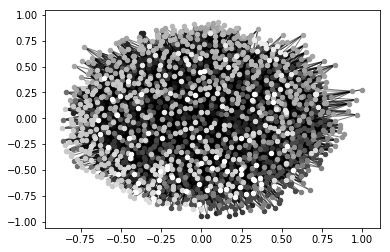

In [74]:
#first compute the best partition
partition = community.best_partition(G, resolution=1)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                node_color = str(count / size))


nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

In [75]:
community.modularity(partition, G)

0.3417348628203124

In [76]:
print list_nodes

['BUS-616', 'BUS-618', 'NUR-606', 'NUR-609', 'ERM-750', 'HIS-515', 'TED-749', 'STA-668', 'MAT-640', 'CRS-787', 'SOC-646', 'NUR-614', 'HHS-750', 'CSC-655', 'BIO-652', 'TED-776', 'CST-698', 'MAT-619', 'ESL-632', 'MBA-741', 'NUR-742', 'BUS-705', 'Topic 4', 'TED-647', 'TED-642', 'TED-761', 'MAT-617', 'MUP-612', 'THR-546', 'ESL-621', 'ESL-622', 'ESL-623', 'HDF-723', 'GEN-671', 'MAT-591', 'BUS-621', 'HEA-604', 'KIN-732', 'MAT-743', 'ESL-611', 'ESL-613', 'ESL-612', 'GES-651', 'ESL-633', 'NUR-506', 'HED-748', 'SWK-853', 'ENS-691', 'MBA-730', 'MUS-662', 'NUR-653', 'ISM-783', 'NUR-898', 'MAT-621', 'NUR-797', 'NUR-701', 'BIO-691', 'ERM-668', 'ESL-631', 'MAT-692', 'MAT-691', 'THR-516', 'PSY-624']


In [77]:
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    print "-"*80
    print "Modularity Cluster: %d" % com
    print list_nodes
    print "-"*80

--------------------------------------------------------------------------------
Modularity Cluster: 0
['PHI-575', 'MUE-618', 'ERM-726', 'BUS-721', 'SWK-650', 'KIN-745', 'KIN-744', 'KIN-746', 'ENG-742', 'NUR-818', 'NUR-810', 'CTR-611', 'NUR-729', 'MAT-747', 'NUR-756', 'NUR-753', 'NUR-612', 'CED-644', 'BIO-655', 'ISM-785', 'THR-685', 'NAN-605', 'THR-612', 'ELC-666', 'THR-539', 'ECO-641', 'ISM-754', 'PSY-763', 'FRE-511', 'NUR-824', 'SOC-651', 'BUS-789', 'Topic 5', 'CSD-671', 'CHE-641', 'ENG-683', 'SES-603', 'MUP-663', 'ELC-615', 'ELC-752', 'THR-680', 'ELC-686', 'MUE-657', 'MUS-706', 'SWK-608', 'KIN-731', 'LIS-649', 'MST-553', 'KIN-644', 'BIO-733', 'CED-650', 'CED-653', 'SES-649', 'SES-641', 'HEA-630', 'DCE-645', 'TED-636', 'SWK-619', 'MBA-720', 'CHE-531', 'CED-779', 'MUS-660', 'PSY-725', 'PSY-727', 'PSY-728', 'CRS-721', 'PHI-559', 'ECO-619', 'CSD-608', 'TED-604', 'ENG-650', 'GES-631', 'HDF-652', 'ENG-549', 'CED-620', 'MUS-698', 'MUE-601', 'NUR-712', 'ART-635', 'MUS-690', 'SWK-631', 'PCS-

In [78]:
df_g = pd.DataFrame(columns=['course_code', 'cluster_num'])

In [79]:
count = 0
for com in set(partition.values()):
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    for each in list_nodes:
        df_g.loc[count] = [each, com]
        count += 1

In [80]:
df_g.head()

,course_code,cluster_num
0,PHI-575,0
1,MUE-618,0
2,ERM-726,0
3,BUS-721,0
4,SWK-650,0


In [81]:
len(df_g)

1648

## Human Labeled Data

In [82]:
l_df = pd.read_csv('../data/Labeled_Dataset/Graduate_Courses_UNCG - Graduate_Courses_UNCG.tsv', sep='\t')

In [83]:
l_df.head()

,ID,course_code,SUBJ_DESC,COLL_DESC,DEPT_DESC,Long_Title,COURSE_DESC,Related_To_Data_Science
0,0,ACC-561,Accounting,Sch of Business and Economics,Accounting and Finance,Governmental and Nonprofit Accounting,This course will introduce students to accounting and financial reporting fo...,0
1,1,ACC-613,Accounting,Sch of Business and Economics,Accounting and Finance,Directed Studies in Accounting,Individual study of an issue or problem of interest. Student must arrange to...,0
2,2,ACC-621,Accounting,Sch of Business and Economics,Accounting and Finance,Accounting Internship,Combined academic and work components allow students to gain experience in t...,0
3,3,ACC-630,Accounting,Sch of Business and Economics,Accounting and Finance,Seminar in Contemporary Accounting Issues,"Analysis, research, and presentation of current topics and issues relevant t...",0
4,4,ACC-631,Accounting,Sch of Business and Economics,Accounting and Finance,Advanced Auditing,"Ethics, reporting, law, statistics, and audit software; directed towards pro...",0


In [84]:
len(l_df)

1671

In [85]:
test = l_df.drop_duplicates('course_code')
len(test)

1603

In [86]:
df_super = pd.merge(l_df, df_g, on = 'course_code', how = 'inner')

In [87]:
df_super.head()

,ID,course_code,SUBJ_DESC,COLL_DESC,DEPT_DESC,Long_Title,COURSE_DESC,Related_To_Data_Science,cluster_num
0,0,ACC-561,Accounting,Sch of Business and Economics,Accounting and Finance,Governmental and Nonprofit Accounting,This course will introduce students to accounting and financial reporting fo...,0,10
1,1,ACC-613,Accounting,Sch of Business and Economics,Accounting and Finance,Directed Studies in Accounting,Individual study of an issue or problem of interest. Student must arrange to...,0,8
2,2,ACC-621,Accounting,Sch of Business and Economics,Accounting and Finance,Accounting Internship,Combined academic and work components allow students to gain experience in t...,0,6
3,3,ACC-630,Accounting,Sch of Business and Economics,Accounting and Finance,Seminar in Contemporary Accounting Issues,"Analysis, research, and presentation of current topics and issues relevant t...",0,2
4,4,ACC-631,Accounting,Sch of Business and Economics,Accounting and Finance,Advanced Auditing,"Ethics, reporting, law, statistics, and audit software; directed towards pro...",0,1


In [88]:
len(df_super)

1671

In [89]:
len(df_super.course_code.unique())

1603

##### Number of labeled datascience courses

In [90]:
df_super.Related_To_Data_Science.value_counts()

0    1546
1     125
Name: Related_To_Data_Science, dtype: int64

## Chi Square Contingency test

**H0** - There is no significant difference between the cluster frequencies and number of courses related to data-science


**H1** - There is a significant difference between the cluster frequencies and number of courses related to data-science

In [91]:
cross_tab = df_super.groupby(['cluster_num']).Related_To_Data_Science.value_counts().unstack('cluster_num', fill_value=0)
cross_tab.head()

cluster_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Related_To_Data_Science,,,,,,,,,,,,,,
0,94,136,161,171,92,58,94,63,190,106,196,74,52,59
1,4,24,0,10,3,3,4,1,3,57,6,3,0,7


In [92]:
from scipy import stats 

res =  stats.chi2_contingency(cross_tab)

print("Chi-Sq Value: %f" % res[0])
print("p-value: %f" % res[1])
print("DOF: %d" % res[2])
print("Expected values:")
print(res[3])

Chi-Sq Value: 237.003163
p-value: 0.000000
DOF: 13
Expected values:
[[ 90.66906044 148.03111909 148.95631358 167.46020347  87.89347696
   56.43686415  90.66906044  59.21244764 178.5625374  150.80670257
  186.88928785  71.23997606  48.1101137   61.06283662]
 [  7.33093956  11.96888091  12.04368642  13.53979653   7.10652304
    4.56313585   7.33093956   4.78755236  14.4374626   12.19329743
   15.11071215   5.76002394   3.8898863    4.93716338]]


***p-value*** less than 0.05 - ***reject the null hypothesis***

#### Test per class 
**H0** - There is no significant difference between the cluster frequencies and negative related courses to datascience


**H1** - There is a significant difference between the cluster frequencies and negative related courses to datascience

In [93]:
obs_0 = cross_tab.iloc[0].values
print(obs_0)

[ 94 136 161 171  92  58  94  63 190 106 196  74  52  59]


In [94]:
exp_0 = np.empty(len(obs_0))
exp_0.fill(int(obs_0.sum()/len(obs_0)))
print(exp_0)

[110. 110. 110. 110. 110. 110. 110. 110. 110. 110. 110. 110. 110. 110.]


In [95]:
stats.chisquare(obs_0, f_exp=exp_0)

Power_divergenceResult(statistic=307.45454545454544, pvalue=6.617896119342736e-58)

***p-value*** less than 0.05 - ***reject the null hypothesis***

**H0** - There is no significant difference between the cluster frequencies and positive related courses to datascience


**H1** - There is a significant difference between the cluster frequencies and positive related courses to datascience

In [96]:
obs_1 = cross_tab.iloc[1].values
print(obs_1)

[ 4 24  0 10  3  3  4  1  3 57  6  3  0  7]


In [97]:
exp_1 = np.empty(len(obs_1))
exp_1.fill(int(obs_1.sum()/len(obs_1)))
print(exp_1)

[8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]


In [98]:
stats.chisquare(obs_1, f_exp=exp_1)

Power_divergenceResult(statistic=371.875, pvalue=1.921482334254292e-71)

***p-value*** less than 0.05 - ***reject the null hypothesis***

#### Individual Cluster Chi Square

In [99]:
df_super_cat = pd.get_dummies(df_super, columns=['cluster_num'])

In [100]:
df_super_cat.head()

,ID,course_code,SUBJ_DESC,COLL_DESC,DEPT_DESC,Long_Title,COURSE_DESC,Related_To_Data_Science,cluster_num_0,cluster_num_1,cluster_num_2,cluster_num_3,cluster_num_4,cluster_num_5,cluster_num_6,cluster_num_7,cluster_num_8,cluster_num_9,cluster_num_10,cluster_num_11,cluster_num_12,cluster_num_13
0,0,ACC-561,Accounting,Sch of Business and Economics,Accounting and Finance,Governmental and Nonprofit Accounting,This course will introduce students to accounting and financial reporting fo...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,ACC-613,Accounting,Sch of Business and Economics,Accounting and Finance,Directed Studies in Accounting,Individual study of an issue or problem of interest. Student must arrange to...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,ACC-621,Accounting,Sch of Business and Economics,Accounting and Finance,Accounting Internship,Combined academic and work components allow students to gain experience in t...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,3,ACC-630,Accounting,Sch of Business and Economics,Accounting and Finance,Seminar in Contemporary Accounting Issues,"Analysis, research, and presentation of current topics and issues relevant t...",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,4,ACC-631,Accounting,Sch of Business and Economics,Accounting and Finance,Advanced Auditing,"Ethics, reporting, law, statistics, and audit software; directed towards pro...",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### F1-Score analysis per cluster

In [101]:
from sklearn.metrics import classification_report, f1_score
for each in df_super_cat.columns[8:]:
    print("="*80)
    print("Cluster: %s" % each)
    print(classification_report(df_super_cat.Related_To_Data_Science, df_super_cat[each], target_names=['0','1']))
    print("F1-Score: %f" % f1_score(df_super_cat.Related_To_Data_Science, df_super_cat[each]))
    print("="*80)

Cluster: cluster_num_0
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1546
           1       0.04      0.03      0.04       125

   micro avg       0.87      0.87      0.87      1671
   macro avg       0.48      0.49      0.48      1671
weighted avg       0.86      0.87      0.86      1671

F1-Score: 0.035874
Cluster: cluster_num_1
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1546
           1       0.15      0.19      0.17       125

   micro avg       0.86      0.86      0.86      1671
   macro avg       0.54      0.55      0.55      1671
weighted avg       0.87      0.86      0.87      1671

F1-Score: 0.168421
Cluster: cluster_num_2
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1546
           1       0.00      0.00      0.00       125

   micro avg       0.83      0.83      0.83      1671
   macro avg       0.

In [102]:
from sklearn.feature_selection import chi2


res = chi2(df_super_cat.iloc[:, 8:], df_super_cat['Related_To_Data_Science'])
features = pd.DataFrame({
    'features': df_super_cat.columns[8:],
    'chi2': res[0],
    'p-value': res[1]
})

In [103]:
features.head(20)

,chi2,features,p-value
0,1.635840,cluster_num_0,2.008972e-01
1,13.071501,cluster_num_1,2.998227e-04
2,13.017464,cluster_num_2,3.085994e-04
3,1.000257,cluster_num_3,3.172484e-01
4,2.564828,cluster_num_4,1.092644e-01
5,0.578758,cluster_num_5,4.467996e-01
6,1.635840,cluster_num_6,2.008972e-01
7,3.238700,cluster_num_7,7.191768e-02
8,9.793444,cluster_num_8,1.751351e-03
9,177.963837,cluster_num_9,1.348997e-40


#### Cluster Correlation Plot

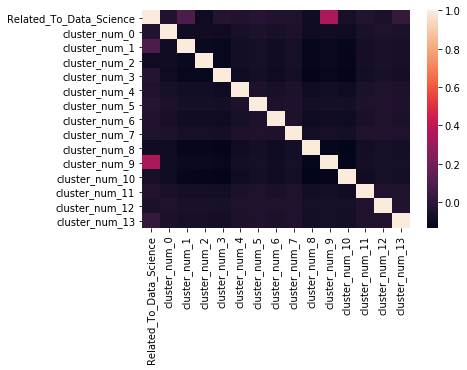

In [104]:
import seaborn as sns

corr = df_super_cat.iloc[:, 7:].corr()
sns.heatmap(corr,
            xticklabels=corr.columns,
            yticklabels=corr.columns)
plt.show()

#### Cluster to Data Science Course Hypothesis

In [105]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

In [106]:
for each in df_super_cat.columns[8:]:
    print("-"*80)
    print("Comparing for: %s" % each)
    stat, p = mannwhitneyu(df_super_cat.Related_To_Data_Science,df_super_cat[each])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')
    print("-"*80)

--------------------------------------------------------------------------------
Comparing for: cluster_num_0
Statistics=1373562.000, p=0.031
Different distribution (reject H0)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Comparing for: cluster_num_1
Statistics=1366878.000, p=0.015
Different distribution (reject H0)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Comparing for: cluster_num_2
Statistics=1366042.500, p=0.013
Different distribution (reject H0)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Comparing for: cluster_num_3
Statistics=1349332.500, p=0.000
Different distribution (reject H0)
-------------------------------------------------

/home/sdmohant/.virtualenvs/datascience2/local/lib/python2.7/site-packages/scipy/stats/stats.py:4974: DeprecationWarning:

Calling `mannwhitneyu` without specifying `alternative` is deprecated.

/home/sdmohant/.virtualenvs/datascience2/local/lib/python2.7/site-packages/scipy/stats/stats.py:4974: DeprecationWarning:

Calling `mannwhitneyu` without specifying `alternative` is deprecated.

/home/sdmohant/.virtualenvs/datascience2/local/lib/python2.7/site-packages/scipy/stats/stats.py:4974: DeprecationWarning:

Calling `mannwhitneyu` without specifying `alternative` is deprecated.

/home/sdmohant/.virtualenvs/datascience2/local/lib/python2.7/site-packages/scipy/stats/stats.py:4974: DeprecationWarning:

Calling `mannwhitneyu` without specifying `alternative` is deprecated.

/home/sdmohant/.virtualenvs/datascience2/local/lib/python2.7/site-packages/scipy/stats/stats.py:4974: DeprecationWarning:

Calling `mannwhitneyu` without specifying `alternative` is deprecated.

/home/sdmohant/.virtualen

In [107]:
for each in df_super_cat.columns[8:]:
    print("-"*80)
    print("Comparing for: %s" % each)
    stat, p = wilcoxon(df_super_cat.Related_To_Data_Science,df_super_cat[each])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')
    print("-"*80)

--------------------------------------------------------------------------------
Comparing for: cluster_num_0
Statistics=10152.000, p=0.066
Same distribution (fail to reject H0)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Comparing for: cluster_num_1
Statistics=12019.000, p=0.023
Different distribution (reject H0)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Comparing for: cluster_num_2
Statistics=17937.500, p=0.033
Different distribution (reject H0)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Comparing for: cluster_num_3
Statistics=16502.500, p=0.001
Different distribution (reject H0)
------------------------------------------------------

#### Calculate metrics for cluster performance

###### ZScore on Freq Counts

In [108]:
cross_tab

cluster_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Related_To_Data_Science,,,,,,,,,,,,,,
0,94,136,161,171,92,58,94,63,190,106,196,74,52,59
1,4,24,0,10,3,3,4,1,3,57,6,3,0,7


In [109]:
float(cross_tab.iloc[0].sum() / cross_tab.iloc[1].sum())

12.0

In [110]:
scores = []
for each in cross_tab.columns:
    print each
    print(cross_tab.iloc[1][each], cross_tab.iloc[0][each])
    q = float((cross_tab.iloc[1][each] * 12) - cross_tab.iloc[0][each]) / float((cross_tab.iloc[1][each] + cross_tab.iloc[0][each]))
    print q
    scores.append(q)

0
(4, 94)
-0.469387755102
1
(24, 136)
0.95
2
(0, 161)
-1.0
3
(10, 171)
-0.281767955801
4
(3, 92)
-0.589473684211
5
(3, 58)
-0.360655737705
6
(4, 94)
-0.469387755102
7
(1, 63)
-0.796875
8
(3, 190)
-0.79792746114
9
(57, 106)
3.54601226994
10
(6, 196)
-0.613861386139
11
(3, 74)
-0.493506493506
12
(0, 52)
-1.0
13
(7, 59)
0.378787878788


In [111]:
stats.zscore(scores)

array([-0.28631471,  0.95772699, -0.75137702, -0.12187278, -0.39156565,
       -0.19101505, -0.28631471, -0.57334536, -0.5742678 ,  3.23303725,
       -0.41294059, -0.3074539 , -0.75137702,  0.45708036])

##### Entropy

In [112]:
from scipy.stats import entropy
from math import log, e


def pandas_entropy(labels, base=2):
    """ Computes entropy of label distribution. """
    n_labels = sum(labels)

    if n_labels <= 1:
        return 0

    value = np.array([0,1])
    
    counts = labels
    probs = counts.astype(float) / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

    # Compute entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)

    return ent

scores = []
for each in cross_tab.columns:
    print '='*80
    print each
    print cross_tab[each]
    q = pandas_entropy(cross_tab[each], base=2)
    print(q)
    print '='*80
    scores.append(q)
a = np.array(scores)
print np.mean(a)

0
Related_To_Data_Science
0    94
1     4
Name: 0, dtype: int64
0.24602257822
1
Related_To_Data_Science
0    136
1     24
Name: 1, dtype: int64
0.609840304716
2
Related_To_Data_Science
0    161
1      0
Name: 2, dtype: int64
0
3
Related_To_Data_Science
0    171
1     10
Name: 3, dtype: int64
0.308287539048
4
Related_To_Data_Science
0    92
1     3
Name: 4, dtype: int64
0.202249424548
5
Related_To_Data_Science
0    58
1     3
Name: 5, dtype: int64
0.28290479298
6
Related_To_Data_Science
0    94
1     4
Name: 6, dtype: int64
0.24602257822
7
Related_To_Data_Science
0    63
1     1
Name: 7, dtype: int64
0.116115075305
8
Related_To_Data_Science
0    190
1      3
Name: 8, dtype: int64
0.11563085548
9
Related_To_Data_Science
0    106
1     57
Name: 9, dtype: int64
0.933793804592
10
Related_To_Data_Science
0    196
1      6
Name: 10, dtype: int64
0.192900074579
11
Related_To_Data_Science
0    74
1     3
Name: 11, dtype: int64
0.237508143829
12
Related_To_Data_Science
0    52
1     0
Name: 12, 

### Single Compute - Optimize Code

In [114]:
def hellinger(X):
    return squareform(pdist(np.sqrt(X)))/np.sqrt(2)
    
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get topics in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            sent_topics_df = sent_topics_df.append(pd.Series([int(i), data_ready[i], int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    sent_topics_df.columns = ['Document_no','Document_Text','Topic', 'Perc_Contribution', 'Topic_Keywords']
    sent_topics_df['Document_no'] = sent_topics_df.Document_no.apply(lambda x : str(int(x)))
    return(sent_topics_df)

def create_network_data(grad_df, grad_cleaned, df_topic_sents_keywords):
    merged = pd.merge(df_topic_sents_keywords, grad_cleaned, on = 'Document_no', how = 'left')
    grouped = merged.groupby(['Document_no','Topic','Perc_Contribution', 'course_code'])
    all_groups = list(grouped.groups.keys())
    edges = [(i[-1], 'Topic ' + str(int(i[1])), {'weight': i[2]}) for i in all_groups]
    merged['Document_Text'] = [', '.join(i for i in j) for j in merged.Document_Text]
    merged['Topic'] = merged.Topic.apply(lambda x : 'Topic ' + str(int(x)))
    merged_clean = merged[['Document_no','Document_Text','Long_Title','SUBJ_DESC','COLL_DESC', 'course_code']]
    merged_clean.drop_duplicates(['Document_no','Document_Text','Long_Title','SUBJ_DESC','COLL_DESC'], inplace = True)
    topic_df = merged.groupby(['Topic','Topic_Keywords']).size().reset_index()
    topic_df['Long_Title'] = topic_df.Topic_Keywords
    topic_df['Document_no'] = topic_df.Topic
    topic_df['course_code'] = topic_df.Topic
    topic_df.pop(0);
    topic_df.pop('Topic_Keywords');
    topic_df.pop('Topic');
    check_df = pd.concat([merged_clean,topic_df])
    check_df.fillna('empty',inplace = True)
    doc_attr = {i : {'Document_Text': '', 'Long_Title': '', 'COLL_DESC': '', 'SUBJ_DESC': ''} for i in check_df.course_code}

    for i in check_df.course_code:
        current = check_df.loc[check_df.course_code == i]
        doc_attr[i]['Document_Text'] = current.Document_Text.values[0]
        doc_attr[i]['Long_Title'] = current.Long_Title.values[0]
        doc_attr[i]['SUBJ_DESC'] = current.SUBJ_DESC.values[0]
        doc_attr[i]['COLL_DESC'] = current.COLL_DESC.values[0]
    check = list(merged.course_code.unique())
    check.extend(list(merged.Topic.unique()))
    
    return check

def create_partition_df(partition):
    df_g = pd.DataFrame(columns=['course_code', 'cluster_num'])
    count = 0
    for com in set(partition.values()):
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        for each in list_nodes:
            df_g.loc[count] = [each, com]
            count += 1
    return df_g

def cal_scores(cross_tab):
    scores = []
    for each in cross_tab.columns:
        q = float((cross_tab.iloc[1][each] * 12) - cross_tab.iloc[0][each]) / float((cross_tab.iloc[1][each] + cross_tab.iloc[0][each]))
        scores.append(q)
    return scores

def pandas_entropy(labels, base=2):
    """ Computes entropy of label distribution. """
    n_labels = sum(labels)

    if n_labels <= 1:
        return 0

    value = np.array([0,1])
    
    counts = labels
    probs = counts.astype(float) / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

    # Compute entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)

    return ent

def cal_entropy(cross_tab):
    scores = []
    for each in cross_tab.columns:
        q = pandas_entropy(cross_tab[each], base=2)
        scores.append(q)
    a = np.array(scores)
    
    return a, np.mean(a)

def cal_model_scores(corpus, data_ready, grad_cleaned, model):
#     Topic model
#     model = gensim.models.ldamulticore.LdaModel(corpus=corpus, num_topics= 25,
#                                                 id2word=id2word, alpha='asymmetric', passes=15, eta= 'auto', decay=0.5, eval_every=1,
#                                                 chunksize=200, random_state = 10)

    X = model.state.get_lambda()
    X = X / X.sum(axis=1)[:, np.newaxis] # normalize vector
    h = hellinger(X)

    df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=data_ready)

    
    check = create_network_data(grad_df, grad_cleaned, df_topic_sents_keywords)
    
    G = nx.Graph()

    G.add_nodes_from(check)
    nx.set_node_attributes(G,doc_attr) #set the new attributes

    G.add_edges_from(edges)
    nx.set_node_attributes(G,doc_attr)
    
    res = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
    perf = []
    for each in res:
        ### Clustering
        partition = community.best_partition(G, resolution=each)
        df_g = create_partition_df(partition)

        l_df = pd.read_csv('../data/Labeled_Dataset/Graduate_Courses_UNCG - Graduate_Courses_UNCG.tsv', sep='\t')

        df_super = pd.merge(l_df, df_g, on = 'course_code', how = 'inner')
        cross_tab = df_super.groupby(['cluster_num']).Related_To_Data_Science.value_counts().unstack('cluster_num', fill_value=0)
        df_super_cat = pd.get_dummies(df_super, columns=['cluster_num'])

        print "=="*80
        print cross_tab
        scores = cal_scores(cross_tab)
        course_dist_mean = np.mean(np.array(scores))
        z_scores = stats.zscore(scores)
        print "Mean score of course distribution: %f" % course_dist_mean
        print "Variance in the scores: %f" % stats.variation(scores)
        print "Z-scores of course distribution:"
        print z_scores

        
        print '\n'

        ent_scores, ent_mean = cal_entropy(cross_tab)
        
        A0 = cross_tab.iloc[0]
        A1 = cross_tab.iloc[1]
        pA0 = A0 / A0.sum()
        SE0 = -np.sum(pA0*np.log2(A0))
        pA1 = A1 / A1.sum()
        SE1 = -np.sum(pA1*np.log2(A1))
   
        print "Mean entropy across clusters (entropy calculated within clusters): %f" % np.max(ent_scores)
        print "Mean entropy across clusters (Class: 0): %f" % SE0
        print "Mean entropy across clusters (Class: 1): %f" % SE1
        print "=="*80
        perf.append([course_dist_mean, stats.variation(scores), np.max(ent_scores), SE0, SE1, len(scores)])
    return perf
perf = cal_model_scores(corpus, data_ready, grad_cleaned, model)

/home/sdmohant/.virtualenvs/datascience2/lib/python2.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/sdmohant/.virtualenvs/datascience2/lib/python2.7/site-packages/ipykernel_launcher.py:37: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




cluster_num              0   1   2   3    4   5   6   7   8   9   10  11  12  \
Related_To_Data_Science                                                        
0                        89  70  59  45  102  75  67  71  51  38  40  37  72   
1                         4   0  13   0    5   1   3   5  18   1   1   2   4   

cluster_num              13  14  15  16   17  18  19  20  21  22  23  24  29  \
Related_To_Data_Science                                                        
0                        65  64  64  59  114  75  73  61  44   5  47  39   4   
1                        44   0   1   3    3   5   0  10   1   0   0   1   0   

cluster_num              30  31  32  34  36  
Related_To_Data_Science                      
0                        12   1   1   1   1  
1                         0   0   0   0   0  
Mean score of course distribution: -0.349763
Variance in the scores: -3.209606
Z-scores of course distribution:
[-0.08114777 -0.5792221   1.51165243 -0.5792221  -0.03808994 -

/home/sdmohant/.virtualenvs/datascience2/lib/python2.7/site-packages/ipykernel_launcher.py:160: RuntimeWarning:

divide by zero encountered in log2



cluster_num              0   1   2   3    4   5   6   7   8   9   10  11  12  \
Related_To_Data_Science                                                        
0                        96  52  58  33  141  78  66  72  80  26  40  77  89   
1                         4  14  12   0    9   3   2   3   0   0   1   4  50   

cluster_num              13   14  15  16  17  18  19  20  21  22  23  
Related_To_Data_Science                                               
0                        68  154  56  48  56  75  60  16  37  40  28  
1                         0    6   1   1   0   5   9   0   1   0   0  
Mean score of course distribution: -0.285982
Variance in the scores: -3.794035
Z-scores of course distribution:
[-0.17881359  1.88341643  1.39586708 -0.65806423  0.06081173 -0.21431364
 -0.30567405 -0.17881359 -0.65806423 -0.65806423 -0.36583823 -0.06639677
  3.65174366 -0.65806423 -0.20876675 -0.44786658 -0.4135486  -0.65806423
  0.09076489  0.90470959 -0.65806423 -0.34276776 -0.65806423 -0.

/home/sdmohant/.virtualenvs/datascience2/local/lib/python2.7/site-packages/scipy/stats/stats.py:2281: RuntimeWarning:

invalid value encountered in true_divide



8 [0 1 2 3 4 5 6 7]
[-0.34976347896868876, -0.2859823826690379, -0.21085134198980682, -0.00697134776446163, -0.2715341087081532, -0.0906605377208668, -0.3600504282694946, -0.02752842609216038]


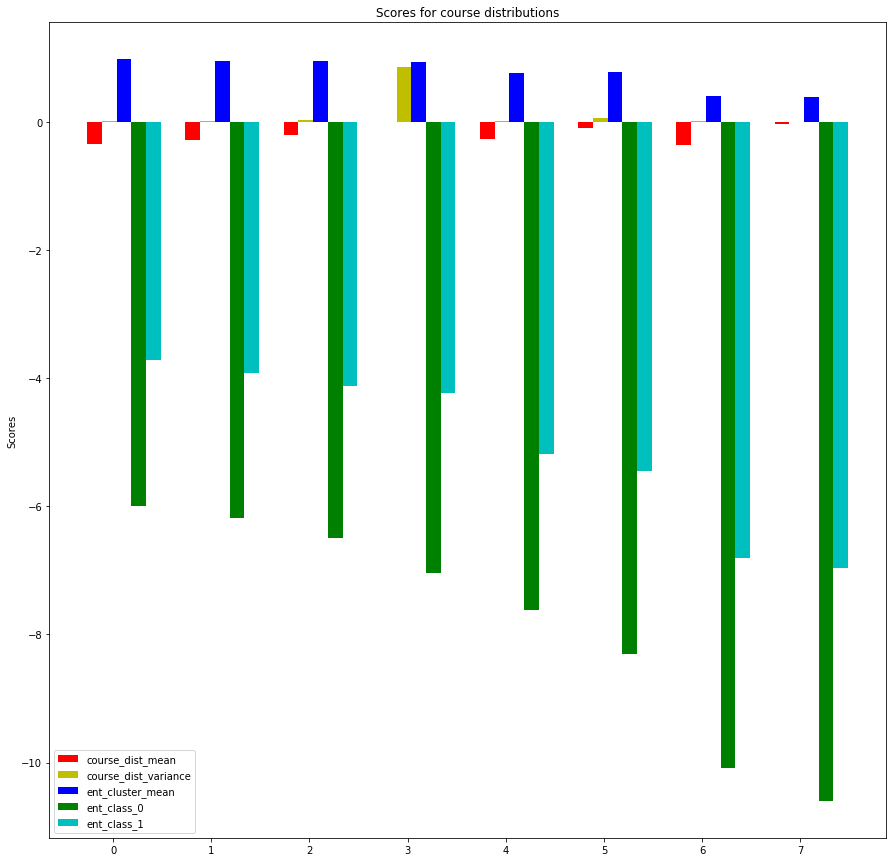

In [115]:
N = len(perf)
ind = np.arange(N)
width = 0.15       # the width of the bars
print N,ind

fig, ax = plt.subplots(figsize=(15,15))


course_dist_mean = [score[0] for score in perf]
course_dist_var = [score[1] for score in perf]
course_dist_var = [float(i)/sum(course_dist_var) for i in course_dist_var]
ent_mean = [score[2] for score in perf]
ent_class_0 = [score[3] for score in perf]
ent_class_1 = [score[4] for score in perf]

print course_dist_mean
rects1 = ax.bar(ind, course_dist_mean, width, color='r')
rects2 = ax.bar(ind + width, course_dist_var, width, color='y')
rects3 = ax.bar(ind + 2*width, ent_mean, width, color='b')
rects4 = ax.bar(ind + 3*width, ent_class_0, width, color='g')
rects5 = ax.bar(ind + 4*width, ent_class_1, width, color='c')


# add some text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Scores for course distributions')
ax.set_xticks(ind + 2.5*width / 2)
ax.set_xticklabels(ind)

ax.legend((rects1, rects2, rects3, rects4, rects5), ('course_dist_mean','course_dist_variance', 'ent_cluster_mean', 'ent_class_0', 'ent_class_1'))